In [386]:
import random
import numpy as np
import matplotlib.pyplot as plt

from numpy import pi as π

import perceval as pv
from scipy.optimize import minimize
from perceval.components import *

from collections import Counter

from submission.circuits import fullCircuit
import matplotlib.pyplot as plt
LAMBDA = 1

In [387]:
# Fraction of [1, 0, x, y] states
def getFidelityRho1(counts):
    totCounts, validCounts = 0, 0

    for state in counts:
        totCounts += counts[state]
        if state[0] == 1 and state[1] == 0:
            validCounts += counts[state]
    if totCounts == 0: 
        return  1   
    return validCounts/totCounts


# Fraction of [x, y, 1, 0] states
def getFidelityRho2(counts):
    totCounts, validCounts = 0, 0

    for state in counts:
        totCounts += counts[state]
        if state[2] == 1 and state[3] == 0:
            validCounts += counts[state]
    if totCounts == 0: 
        return 1
    return validCounts/totCounts

def getFidelities(counts):
    return (getFidelityRho1(counts), getFidelityRho2(counts))

def costFunctionAtPhi(counts):
    return (1 - getFidelityRho1(counts))**2 + (1 - getFidelityRho2(counts))**2 + (getFidelityRho1(counts)-getFidelityRho2(counts))**2

In [388]:
# Fraction of [1, 0, x, y] states
def getProb(counts):
    totCounts, validCounts = 0, 0

    for state in counts:
        totCounts += counts[state]
        if (state[0] == 1 and state[1] == 0) or (state[2]==1 and state[3]==0):
            validCounts += counts[state]

    return validCounts/totCounts



def costFunctionAtState(counts):
    '''get the cost function terms relative either to A or B
    IT DOES NOT INCLUED THE PROBABILITY TERM'''

    return (
            (1 - getFidelityRho1(counts))**2 + 
            (1 - getFidelityRho2(counts))**2 + 
            (getFidelityRho1(counts)-getFidelityRho2(counts))**2 
        )

def loss_function_SD(theta = [0] * 12, A_angles = [0,0], B_angles=[0,0]):
# def loss_function_SD(theta = [0] * 12):
    # A_angles = [0,0]
    # B_angles=[0,0]
    cost = 0
    # print(f'theta{type(theta[0])} \n A_angles{type(A_angles[0])}')
    states_angles = [ A_angles, B_angles ]
    # holds the valid counts for A and B respectively
    valid_counts_A_B = [0,0]
    total_counts = [0,0]
    # Evaluate the 4 cost functions, one for each fidelity
    for state_idx, state in enumerate(states_angles):
        circuit = fullCircuit(theta_params=theta, prepTheta=state[0], prepPhi=state[1])
        p = pv.Processor("SLOS", circuit)
        p.with_input(pv.BasicState([0, 1, 0, 1]))

        # The sampler holds 'probs', 'sample_count' and 'samples' calls. You can use the one that fits your needs!
        sampler = pv.algorithm.Sampler(p)  
        sample_count = sampler.sample_count(1000)['results']

        valid_counts = {}
        for c in sample_count:
            if c[0] != c[1] and c[2] != c[3]: #Since we introduce only 2 photons in the circuit it is enough
                valid_counts[c] = sample_count[c]
                valid_counts_A_B[state_idx] += sample_count[c]
            total_counts[state_idx] += sample_count[c]

        cost += costFunctionAtState(valid_counts)
    PA = valid_counts_A_B[0]/total_counts[0]
    PB = valid_counts_A_B[1]/total_counts[1]
    print(f"PA:{PA}\tPB:{PB}")
    cost += LAMBDA*((1-PA)**2 + (1-PB)**2 + (PA-PB)**2)
    return cost




In [389]:
def computeFidelity(x0, state_angles):

    circuit = fullCircuit(theta_params=x0, prepTheta=state_angles[0], prepPhi=state_angles[1])

    p = pv.Processor("SLOS", circuit)
    p.with_input(pv.BasicState([0, 1, 0, 1]))

    # The sampler holds 'probs', 'sample_count' and 'samples' calls. You can use the one that fits your needs!
    sampler = pv.algorithm.Sampler(p)  
    sample_count = sampler.sample_count(1000)['results']
    
    valid_counts = {}
    for c in sample_count:
        if c[0] != c[1] and c[2] != c[3]: #Since we introduce only 2 photons in the circuit it is enough
            valid_counts[c] = sample_count[c]

    # print(valid_counts)
    fr1 = getFidelityRho1(valid_counts)
    fr2 = getFidelityRho2(valid_counts)

    # print(fr1)
    # print(fr2)

    return fr1, fr2

In [390]:
def optimCallback(intermediate_result):
    
    outLine = f'{intermediate_result.fun:0.3f}, '
    for x in intermediate_result.x:
        outLine += f'{x}, '
    outLine += '\n'

    print(outLine)
    with open('ResultFile.csv', 'a+') as outFile:
        outFile.writelines([outLine])

In [391]:
class ao():
    def __init__(self, x0):
        self.x = x0

def minimizeVal(swapMimimizers, x0 = None, maxIter = 100, target_states =([np.pi/2, np.pi/8], [np.pi/2, -np.pi/8])):
    res = ao((np.random.rand(1, 12)[0])*2*π) if x0 == None else ao(x0)

    # print(res.x)

    with open('ResultFile.csv', 'w') as outFile:
        outFile.writelines('Fun, p0, p1, p2, p3, p4, p5, p6, p7, p8, p9, p10, p11')

    for minimizerSwapIndex in range(swapMimimizers):
        res = minimize(loss_function_SD,
            res.x,
            args=target_states,
            method="Nelder-Mead",
            bounds=[(0, 2*π)]*12,
            callback=optimCallback,
            options={'maxiter':maxIter}
        )
        optimCallback(res)


        res = minimize(loss_function_SD,
            res.x,
            args=target_states,
            method="powell",
            bounds=[(0, 2*π)]*12,
            callback=optimCallback
        )
        optimCallback(res)


    return res

In [ ]:
ts_list = [
    ([np.pi/2, np.pi/8], [np.pi/2, -np.pi/8]), #orange
    ([np.pi/2, np.pi/16], [np.pi/2, -np.pi/16]), #purple
    ([0,0], [np.pi/2, 0]), #blue
    ([0,0], [np.pi/4, 0]), #gree
]
# target_states =([np.pi/2, np.pi/8], [np.pi/2, -np.pi/8])
res_string = ''''''
for target_states in ts_list:
    res = minimizeVal(2, target_states=target_states)
    res_string += (f"({target_states[0][0]}, {target_states[0][1]})\tfidelity A: {computeFidelity(res.x, target_states[0])}\n")
    res_string += (f"({target_states[1][0]}, {target_states[1][1]})\tfidelity B: {computeFidelity(res.x, target_states[1])}\n\n")

PA:0.346	PB:0.502
PA:0.377	PB:0.472
PA:0.395	PB:0.507
PA:0.394	PB:0.517
PA:0.366	PB:0.475
PA:0.379	PB:0.46
PA:0.367	PB:0.474
PA:0.367	PB:0.474
PA:0.363	PB:0.475
PA:0.351	PB:0.47
PA:0.384	PB:0.491
PA:0.376	PB:0.458
PA:0.375	PB:0.485
PA:0.374	PB:0.492
1.399, 1.9921645625952458, 2.412970337207866, 5.1688195767453005, 4.388242046159083, 2.3659599976647385, 1.0934604673776216, 2.907248281969556, 4.152206681746016, 3.242214466837631, 4.349403881686745, 1.5596887413765799, 6.065832622267352, 

PA:0.383	PB:0.512
1.399, 1.9921645625952458, 2.412970337207866, 5.1688195767453005, 4.388242046159083, 2.3659599976647385, 1.0934604673776216, 2.907248281969556, 4.152206681746016, 3.242214466837631, 4.349403881686745, 1.5596887413765799, 6.065832622267352, 

PA:0.389	PB:0.477
1.399, 1.9921645625952458, 2.412970337207866, 5.1688195767453005, 4.388242046159083, 2.3659599976647385, 1.0934604673776216, 2.907248281969556, 4.152206681746016, 3.242214466837631, 4.349403881686745, 1.5596887413765799, 6.0658326

In [395]:
print(res_string)

(1.5707963267948966, 0.39269908169872414) fidelity A: (0.973175965665236, 0.9774678111587983)
(1.5707963267948966, -0.39269908169872414) fidelity B: (0.9488465396188566, 0.9729187562688064)

(1.5707963267948966, 0.19634954084936207) fidelity A: (0.9898682877406282, 0.9949341438703141)
(1.5707963267948966, -0.19634954084936207) fidelity B: (0.9888211382113821, 0.9888211382113821)

(0, 0) fidelity A: (1.0, 1.0)
(1.5707963267948966, 0) fidelity B: (0.9963325183374083, 0.9853300733496333)

(0, 0) fidelity A: (0.9790794979079498, 0.9476987447698745)
(0.7853981633974483, 0) fidelity B: (0.9739583333333334, 0.990625)




In [393]:
import csv

Min cost: 0.003 


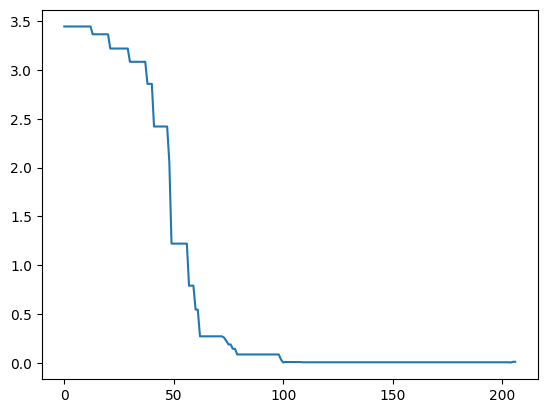

In [394]:
with open('ResultFile.csv', newline='') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')
    next(spamreader)
    costs = []
    minCost = 10
    minConfig = []
    for row in spamreader:
        costs.append(float(row[0]))
        if costs[-1] < minCost:
            minCost = costs[-1]
            minConfig = [float(el) for el in row[1:13]]
        
plt.plot(costs)
print(f'Min cost: {minCost} ')